In [1]:
import osmnx as ox
import streetspace as sp
from building_distance import *

In [2]:
# Use OSMnx to download demo street centerlines and and building footprints from OSM
point = (37.8605545,-122.257566)
dist = 200
G = ox.graph_from_point(point, dist).to_undirected() # Make graph undirected so there aren't dual lines for each street
streets = ox.graph_to_gdfs(G, nodes=False)
buildings = ox.geometries_from_point(point, {'building': True}, dist+100) # Get buildings from a larger radius to avoid edge effects

In [3]:
# Project into local UTM to reduce shape/distance distortion
streets = ox.project_gdf(streets)
buildings = ox.project_gdf(buildings)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fba35ec3510>)

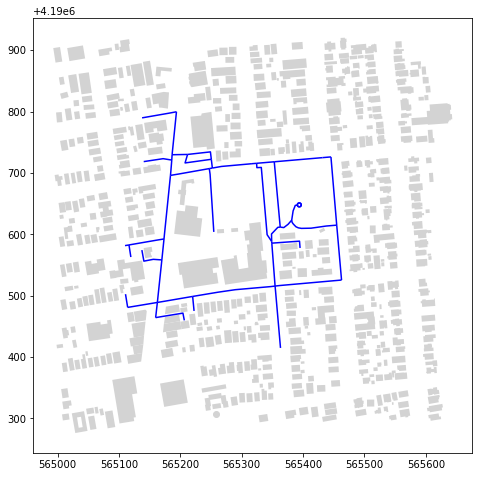

In [4]:
# Preview the streets and buildings we're working with
sp.plot_shapes([
    streets, 
    (buildings, {'color':'lightgray'})
])

In [5]:
# Ensure that buildings are singlepart polygons
buildings = sp.singlepart(buildings)
buildings = buildings[buildings.geometry.apply(lambda x: isinstance(x, Polygon))]

In [6]:
# Make unique IDs for streets and buildings by reseting indices
streets = streets.reset_index().rename(columns={'index':'id'})
buildings = buildings.reset_index().rename(columns={'index':'id'})

In [7]:
# Calculate building distances
building_distances = calculate_building_distances(streets, 'id', buildings, 'id', interval=10)

In [8]:
# Preview full output
building_distances.head()

# There are two records for each point along a street: one for each side of the street.
# `a` and `b` suffixes refer to endpoints of the building facade segment closest to the street point.
# `angle` refers to the angle between the street point and closest building point
# `lat_dist` is the latitudinal distance, perpendicular to the street centerline, of the closest building
# `lon_dist` is the longitudinal distance, parallel to the street centerline, of the closest building

,street_x,street_y,street_angle,street_id,building_xa,building_ya,building_id,building_xb,building_yb,building_x,building_y,building_distance,building_angle,angle_difference,building_side,building_lat_dist,building_lon_dist
448287,565109.843108,4.190582e+06,9.847015,20,565117.086067,4.190593e+06,333,565114.573047,4.190612e+06,565117.086067,4.190593e+06,13.871301,58.523136,-48.676121,0,10.417195,9.159424
448552,565109.843108,4.190582e+06,9.847015,20,565096.873302,4.190557e+06,384,565108.744173,4.190559e+06,565108.744173,4.190559e+06,22.305216,-92.823996,102.671012,1,21.761987,4.892707
806905,565110.602140,4.190502e+06,-80.695051,44,565120.333143,4.190500e+06,423,565117.996035,4.190513e+06,565119.608506,4.190504e+06,9.152050,10.236768,-90.931819,0,9.150839,0.148836
807321,565110.602140,4.190502e+06,-80.695051,44,565106.237695,4.190510e+06,509,565107.391637,4.190505e+06,565107.391637,4.190505e+06,3.869728,146.062368,133.242581,1,2.818941,2.651107
810160,565112.219031,4.190493e+06,-80.695051,44,565140.318353,4.190504e+06,423,565120.333143,4.190500e+06,565120.333143,4.190500e+06,11.037372,42.680202,-123.375253,0,9.217150,6.071880


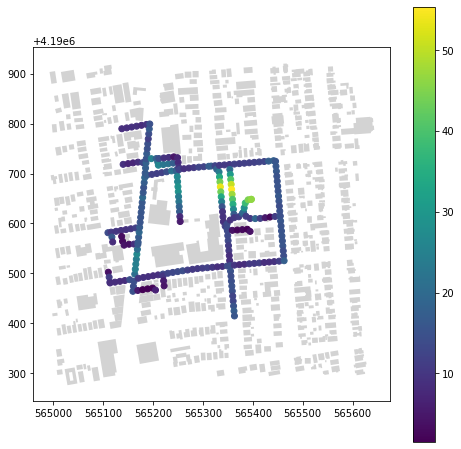

In [9]:
# Map closest distance for each point
min_building_distances = pd.DataFrame(building_distances.groupby(['street_x','street_y']).building_distance.min()).reset_index()
min_building_distances = gpd.GeoDataFrame(
    min_building_distances[['building_distance']], 
    geometry=gpd.points_from_xy(min_building_distances.street_x, min_building_distances.street_y))

fig, ax = sp.plot_shapes([(buildings, {'color':'lightgray'})])
min_building_distances.plot(column='building_distance', legend=True, ax=ax)